In [1]:
import sys

sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

In [3]:
from matplotlib.ticker import FuncFormatter

formatter_pct = FuncFormatter(lambda y, pos: "%.f %%" % y)
formatter_bps = FuncFormatter(lambda y, pos: "%.0f" % (10**4 * y))

In [4]:
import dill

loaded_data = None

with open('precomputed_sims/data1.pkl', 'rb') as f:
    loaded_data = dill.load(f)

In [5]:
maturity = loaded_data["randomization"]["maturity"]
udlyings = loaded_data["underlyings"]

In [6]:
import numpy as np

times_cva = np.arange(0, maturity, 0.5)

shifted_times_cva = times_cva + 1.
shifted_times_cva[-1] = maturity

In [7]:
from finance.discountfactor import ConstantRateDiscountFactor 

r = 0.02
discount = ConstantRateDiscountFactor(r)

In [8]:
def compute_varrho_ccp(loss_dfr, cva_t0_dfr, cva_t1_dfr, t0_, t1_, incl_cva):
    rho = loss_dfr.sum(axis=1) 
    
    if incl_cva:
        rho += discount(t1_) * cva_t1_dfr.sum(axis=1)
        rho -= discount(t0_) * cva_t0_dfr.sum(axis=1)
    
    return rho

In [9]:
import pandas as pd
import os

loss_path = './res/aggregated/loss_1y_ahead/'
cva_path = './res/aggregated/cva_ccp/'

#loss_path = './res/sim5/loss_1y_ahead/'
#cva_path = './res/sim5/cva_ccp/'

In [10]:
def compute_1y_ahead_varrho_ccp(times_cva_, shifted_times_cva_, incl_cva=True):
    varrho_ccp = dict()
    
    for t0_, t1_ in zip(times_cva_, shifted_times_cva_):
        cur_loss_int = "[%.2f, %.2f]" % (t0_, t1_)
        loss_path_ = os.path.join(loss_path, 'loss_%s.csv' % cur_loss_int)
        loss_ahead = pd.read_csv(loss_path_, index_col=0, header=0)
    
        cur_t0 = "%.2f" % t0_
        cva_t0_path = os.path.join(cva_path, 'cva_%s.csv' % cur_t0)
        cva_t0 = pd.read_csv(cva_t0_path, index_col=0, header=0)
    
        cur_t1 = "%.2f" % t1_
        cva_t1_path = os.path.join(cva_path, 'cva_%s.csv' % cur_t1)
        cva_t1 = pd.read_csv(cva_t1_path, index_col=0, header=0)
    
        col_names = ['all', 17, 9, 29, 26, 50, 4, 5, 13, 64]
        varrho_ccp_t0_t1 = {}
    
        for col in col_names:
            if col == 'all':
                varrho_ser = compute_varrho_ccp(loss_ahead, cva_t0, cva_t1, t0_, t1_, incl_cva)
            else:
                col = unicode(col)
                loss__ = loss_ahead.drop(col, 1)
                cva_t0__ = cva_t0.drop(col, 1)
                cva_t1__ = cva_t1.drop(col, 1)
            
                varrho_ser = compute_varrho_ccp(loss__, cva_t0__, cva_t1__, t0_, t1_, incl_cva)    
    
            varrho_ccp_t0_t1[col] = varrho_ser
        
        varrho_ccp[cur_loss_int] = pd.DataFrame(varrho_ccp_t0_t1)
    
    return varrho_ccp

In [11]:
varrho_ccp = compute_1y_ahead_varrho_ccp(times_cva, shifted_times_cva, incl_cva=True)

In [12]:
varrho_ccp_time = pd.DataFrame({key: value['all'] for (key, value) in zip(times_cva, varrho_ccp.values())})

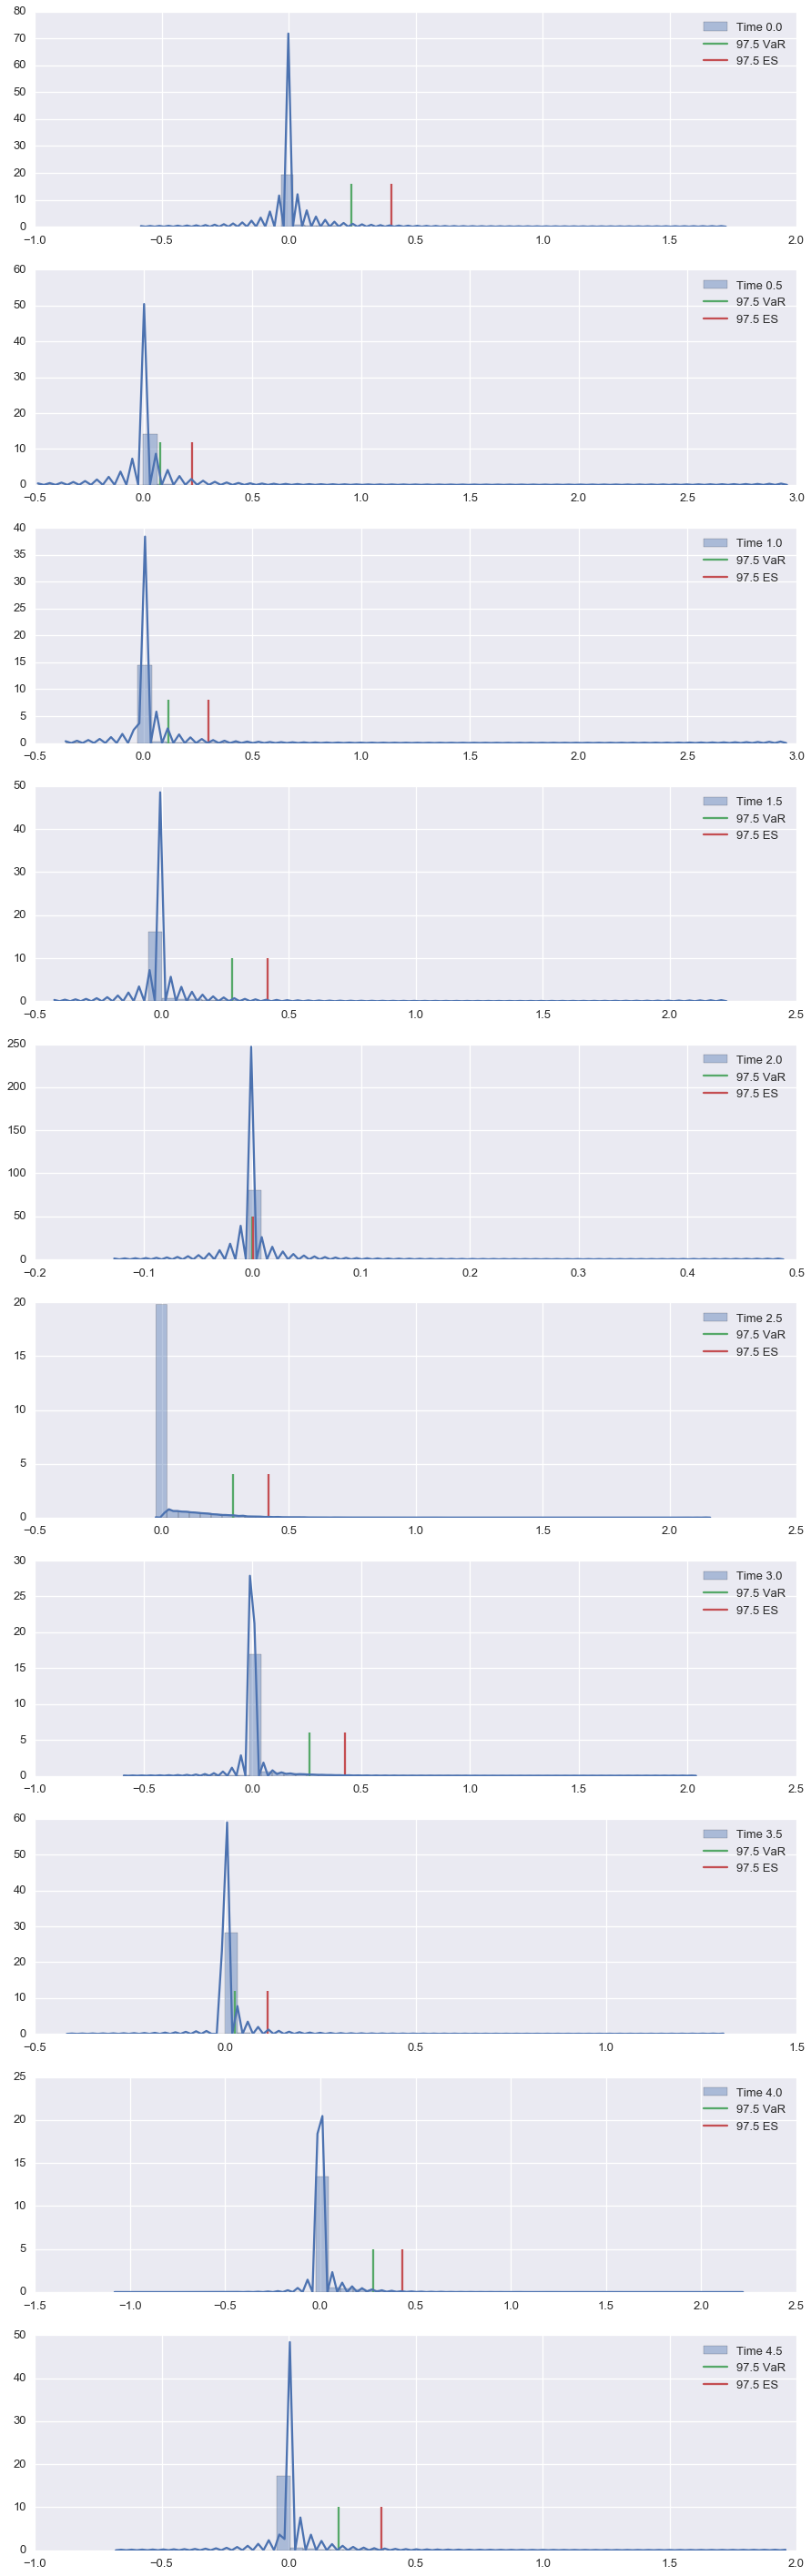

In [39]:
fig, ax = plt.subplots(len(varrho_ccp_time.columns), 1, figsize=(15, 50))

for i, c in enumerate(varrho_ccp_time.columns):
    ax_ = ax[i]
    crt_varrho = varrho_ccp_time[c]
    var = crt_varrho.quantile(0.975, interpolation='linear')
    es = crt_varrho[crt_varrho >= var].mean()
    
    sns.distplot(crt_varrho.values, kde=True, hist=True, ax=ax_, label='Time %s' % c)
    ax_.vlines(var, 0., ax_.get_ylim()[1] / 5., label='97.5 VaR', color=sns.color_palette()[1])
    ax_.vlines(es, 0., ax_.get_ylim()[1] / 5., label='97.5 ES', color=sns.color_palette()[2])
    
    ax_.legend(loc='best')